# 手写数字识别器

重复课堂上讲解的卷积神经网络实例。

In [1]:
# 准备工作，加载所需程序包
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 下载数据
train_data = dsets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
label = 2


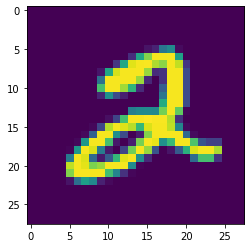

In [3]:
# 简单展示下数据
print(train_data)
print(test_data)
idx = 5
print("label =", train_data[idx][1])
plt.imshow(train_data[idx][0].numpy()[0,...])

In [4]:
# 定义超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64  #一个撮（批次）的大小，64张图片

In [5]:
# 加载训练数据
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [6]:
# 拆分测试数据（为验证集和测试集）
indices = range(len(test_data))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, sampler=sampler_val)

In [7]:
# 定义卷积神经网络
d = [4, 8] # 两个卷积层的厚度（feature map的数量）
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,    d[0], 5, padding=2) # 第一层卷积，输入通道1，输出通道4，窗口大小5，padding为2
        self.conv2 = nn.Conv2d(d[0], d[1], 5, padding=2) # 第二层卷积，输入通道4，输出通道8，窗口大小5，padding为2
        self.pool = nn.MaxPool2d(2, 2)             # 池化层，窗口大小2x2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * d[1], 512) # 线性连接层，输入为最后一层立方体的线性平铺，输出512个节点
        self.fc2 = nn.Linear(512, num_classes)                              # 线性分类层，输入512,输出为分类结果的类别数
    def forward(self, x):
        # x当前尺寸：(batch_size, image_channels, image_width, image_height)
        x = self.conv1(x)
        x = F.relu(x)
        # x当前尺寸：(batch_size, d[0], image_width, image_height)
        x = self.pool(x)
        # x当前尺寸：(batch_size, d[0], image_width/2, image_height/2)
        x = self.conv2(x)
        x = F.relu(x)
        # x当前尺寸：(batch_size, d[1], image_width/2, image_height/2)
        x = self.pool(x)
        # x当前尺寸：(batch_size, d[1], image_width/4, image_height/4)
        x = x.view(-1, (image_size//4)*(image_size//4)*d[1])
        # x当前尺寸：(batch_size, d[1]*(image_width/4)*(image_height/4))
        x = self.fc1(x)
        x = F.relu(x)
        # x当前尺寸：(batch_size, 512)
        x = F.dropout(x, training = self.training) # 以默认0.5的概率进行dropout
        x = self.fc2(x)
        # x当前尺寸：(batch_size, num_classes)
        x = F.log_softmax(x, dim=1)
        return x
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)
        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

In [8]:
# 运行模型
net = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

record = []
weights = []

def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = rightness(output, target)
        train_rights.append(right)
        
        if batch_idx % 100 == 0: #每间隔100个batch执行一次打印等操作    
            net.eval() # 给网络模型做标记，标志说模型在训练集上训练
            val_rights = [] #记录校验数据集准确率的容器
            
            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                right = rightness(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)
            
            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            #train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            #train_r[0]/train_r[1]就是训练集的分类准确度，同样，val_r[0]/val_r[1]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print(val_r)
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))
            
            #将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
            
            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])

(tensor(501), 5000)
训练周期: 0 [0/60000 (0%)]	Loss: 2.300020	训练正确率: 9.38%	校验正确率: 10.02%
(tensor(911), 5000)
训练周期: 0 [6400/60000 (11%)]	Loss: 2.292458	训练正确率: 11.39%	校验正确率: 18.22%
(tensor(1288), 5000)
训练周期: 0 [12800/60000 (21%)]	Loss: 2.291484	训练正确率: 13.13%	校验正确率: 25.76%
(tensor(1732), 5000)
训练周期: 0 [19200/60000 (32%)]	Loss: 2.282560	训练正确率: 15.26%	校验正确率: 34.64%
(tensor(1940), 5000)
训练周期: 0 [25600/60000 (43%)]	Loss: 2.259087	训练正确率: 18.26%	校验正确率: 38.80%
(tensor(2186), 5000)
训练周期: 0 [32000/60000 (53%)]	Loss: 2.204116	训练正确率: 21.07%	校验正确率: 43.72%
(tensor(3092), 5000)
训练周期: 0 [38400/60000 (64%)]	Loss: 1.830243	训练正确率: 24.69%	校验正确率: 61.84%
(tensor(3637), 5000)
训练周期: 0 [44800/60000 (75%)]	Loss: 0.811258	训练正确率: 29.87%	校验正确率: 72.74%
(tensor(3943), 5000)
训练周期: 0 [51200/60000 (85%)]	Loss: 0.562078	训练正确率: 35.57%	校验正确率: 78.86%
(tensor(4224), 5000)
训练周期: 0 [57600/60000 (96%)]	Loss: 0.586949	训练正确率: 40.74%	校验正确率: 84.48%
(tensor(4168), 5000)
训练周期: 1 [0/60000 (0%)]	Loss: 0.464017	训练正确率: 84.38%	校验正确率: 83.36%
(t

In [9]:
# 测试模型
net.eval() # 模型进入运行阶段
vals = []
for data, target in test_loader:
    with torch.no_grad():
        data = Variable(data)
    target = Variable(target)
    output = net(data)
    val = rightness(output, target)
    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].numpy() / rights[1]
(right_rate, rights)

(0.9784, (tensor(4892), 5000))

Text(0, 0.5, 'Error rate')

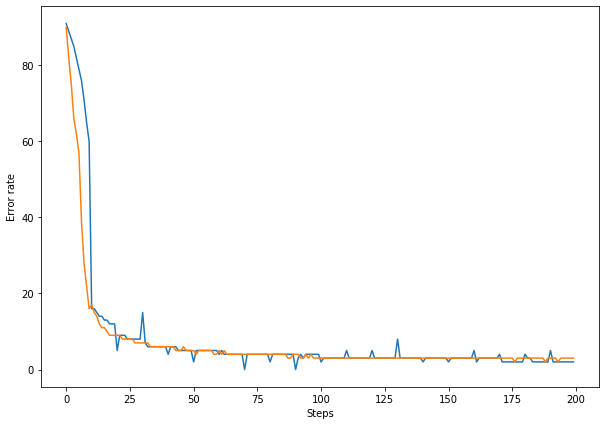

In [10]:
# 误差曲线
plt.figure(figsize = (10, 7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error rate')